In [2]:
# core python 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import ipywidgets
import os
import geological_segmentation as geoseg

# tools in the simPEG Ecosystem 
import discretize  # for creating computational meshes

# linear solvers
from pymatsolver import Pardiso as Solver  # this is a fast linear solver 

# SimPEG inversion machinery
from SimPEG import (
    Data, maps,
    data_misfit, regularization, optimization, inverse_problem, 
    inversion, directives
) 

# DC resistivity and IP modules
from SimPEG.electromagnetics import resistivity as dc
from SimPEG.electromagnetics import induced_polarization as ip

from SimPEG.electromagnetics.static.utils.static_utils import (
    apparent_resistivity_from_voltage,
    plot_pseudosection,
)

# set the font size in the plots
from matplotlib import rcParams
rcParams["font.size"] = 14


In [108]:
# load mesh
mesh = discretize.TensorMesh.read_UBC("/home/juanito/Documents/projects/mcD/dflt/dcinv2d.msh")
actind = np.ones(mesh.n_cells, dtype=bool)

mcd_model =  np.exp(np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/mcd_iterations/model_7.npy"))

segmentor = geoseg.SamClassificationModel(
    mesh,
    segmentation_model_checkpoint=r"/home/juanito/Documents/trained_models/sam_vit_h_4b8939.pth"
)
# segmentor.segment_model.cuda()
masks_iter_2 = segmentor.fit(np.log(mcd_model))

mask 0 vote total: 0
mask 1 vote total: 1
mask 2 vote total: 1
mask 3 vote total: 0
mask 4 vote total: 0
mask 5 vote total: 0
[2]
[[1.00000000e+00 0.00000000e+00 5.19021739e-01 0.00000000e+00
  5.93368237e-02 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 4.51086957e-01 4.81927711e-02
  0.00000000e+00 1.30522088e-01]
 [5.19021739e-01 4.51086957e-01 0.00000000e+00 2.17391304e-02
  3.07971014e-02 5.88768116e-02]
 [0.00000000e+00 4.81927711e-07 2.17391304e-07 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.93368237e-07 0.00000000e+00 3.07971014e-07 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.30522088e-06 5.88768116e-07 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]


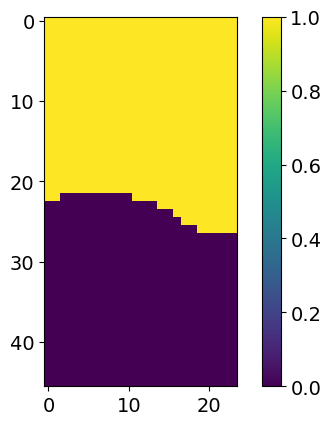

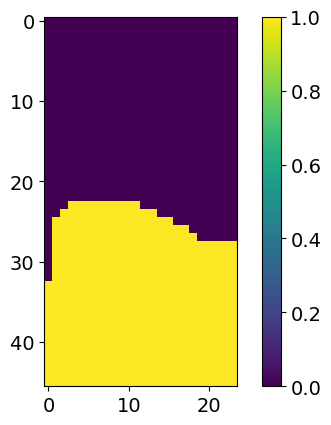

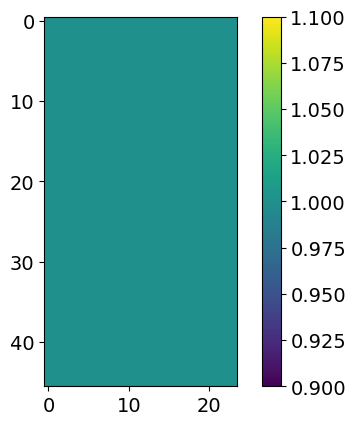

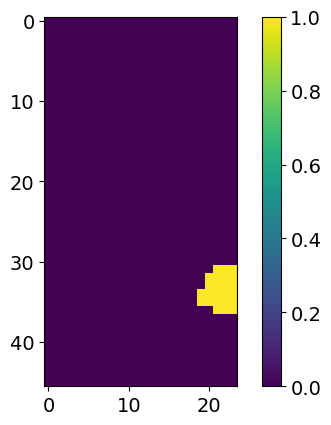

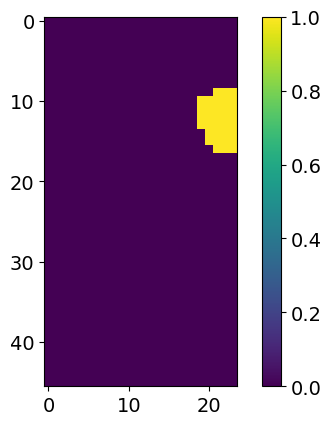

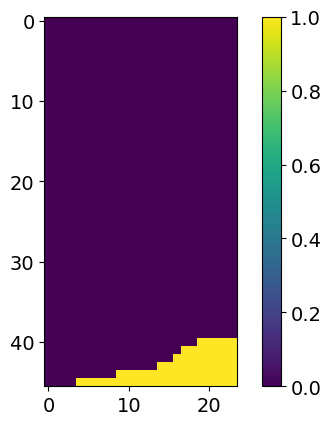

In [115]:
for mask in masks_iter_2:
    plt.imshow(mask['segmentation'])
    plt.colorbar()
    plt.show()

/tmp/ipykernel_142852/1207663909.py:26: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  d = meshCore.plotImage(conductivity_model_log10_true[actcore], clim=clim, ax=ax[0], pcolorOpts={'cmap':"Spectral_r"})
/tmp/ipykernel_142852/1207663909.py:29: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  d1 = meshCore.plotImage(conductivity_model_log10_geoseg[actcore], clim=clim, ax=ax[1], pcolorOpts={'cmap':"Spectral_r"})


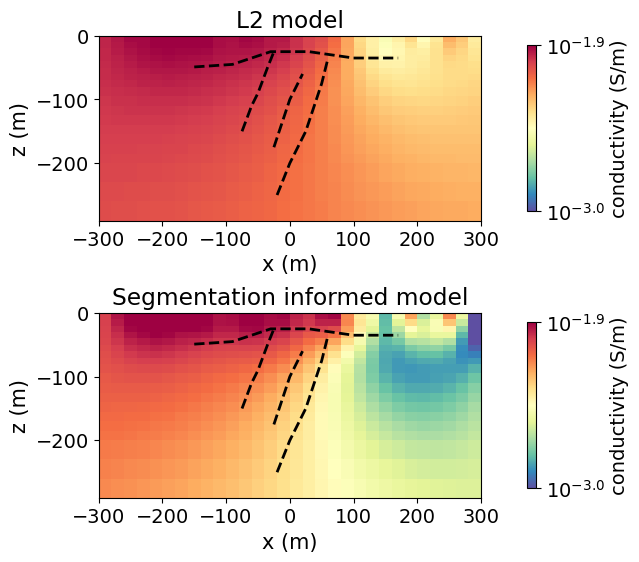

In [104]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
upper_clay = np.array([[-150, -90, -30, 30, 100, 170],
              [-49, -45, -25, -25, -35, -35]])
unit_west = np.array([[-75, -60, -50, -35, -25],
              [-150, -110, -90, -50, -25]])

unit_center = np.array([[-25, 0, 20],
              [-175, -100, -60]])

unit_east = np.array([[-20, 0, 25, 50, 60],
              [-250, -200, -150, -75, -35]])

xmin, xmax = -300., 300.
ymin, ymax = -300., 0.
zmin, zmax = 0, 0
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
from SimPEG import utils
actcore,  meshCore = utils.mesh_utils.extract_core_mesh(xyzlim, mesh)

# mcd_model =  discretize.TensorMesh.read_model_UBC(mesh, r"/home/juanito/Documents/projects/mcD/dflt/dcinv2d.con")
mcd_model =  np.exp(np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/mcd_iterations/model_24.npy"))
mcd_model2 =  np.exp(np.load(r"/home/juanito/Dropbox/JohnLindsey/geoseg/mcd_iterations/model_8.npy"))
conductivity_model_log10_true = np.log10(np.exp(np.log(mcd_model2)))
clim = [conductivity_model_log10_true.min(), conductivity_model_log10_true.max()]
clim = [-3, -1.9]
d = meshCore.plotImage(conductivity_model_log10_true[actcore], clim=clim, ax=ax[0], pcolorOpts={'cmap':"Spectral_r"})
plt.colorbar(d[0], cmap='Spectral_r', label=r'conductivity (S/m)', ticks=[clim[0],clim[1]], format="$10^{%.1f}$", shrink=0.9).ax.tick_params(labelsize=14)
conductivity_model_log10_geoseg = np.log10(np.exp(np.log(mcd_model)))
d1 = meshCore.plotImage(conductivity_model_log10_geoseg[actcore], clim=clim, ax=ax[1], pcolorOpts={'cmap':"Spectral_r"})
plt.colorbar(d1[0], cmap='Spectral_r', label=r'conductivity (S/m)', ticks=[clim[0],clim[1]], format="$10^{%.1f}$", shrink=0.9).ax.tick_params(labelsize=14)

# dd = mesh.plot_image(np.log(1 / mcd_model), ax=ax[0], clim=clim, pcolor_opts={"cmap": "Spectral"})
# dd1 = mesh.plot_image(np.log(1 / mcd_model2), ax=ax[1], clim=clim, pcolor_opts={"cmap": "Spectral"})
ax[0].plot(upper_clay[0, :], upper_clay[1, :], 'k--', lw=2, label="minerlized zone")
ax[0].plot(unit_west[0, :], unit_west[1, :], 'k--', lw=2)
ax[0].plot(unit_center[0, :], unit_center[1, :], 'k--', lw=2)
ax[0].plot(unit_east[0, :], unit_east[1, :], 'k--', lw=2)
ax[1].plot(upper_clay[0, :], upper_clay[1, :], 'k--', lw=2, label="minerlized zone")
ax[1].plot(unit_west[0, :], unit_west[1, :], 'k--', lw=2)
ax[1].plot(unit_center[0, :], unit_center[1, :], 'k--', lw=2)
ax[1].plot(unit_east[0, :], unit_east[1, :], 'k--', lw=2)

ax[0].set_title("L2 model")
ax[1].set_title("Segmentation informed model")
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[0].set_xlabel('x (m)',fontsize=15)
ax[0].set_ylabel('z (m)',fontsize=15)
ax[1].set_xlabel('x (m)',fontsize=15)
ax[1].set_ylabel('z (m)',fontsize=15)
plt.subplots_adjust(hspace=0.5)
# ax[0].legend(loc='lower right')
# ax[1].legend(loc='lower right')
# plt.axis('equal')
# ax[0].set_xlim([-300, 300])
# ax[0].set_ylim([-300, 50])
# ax[1].set_xlim([-300, 300])
# ax[1].set_ylim([-300, 50])

# surface weighting

In [37]:
from SimPEG.electromagnetics.static import utils as sutils
from scipy.spatial import cKDTree

values = np.array([100, 100, 100, 75, 50, 30, 20, 15])

n_layer = values.size

uniqXYlocs, topoCC = sutils.gettopoCC(mesh, actind, option='center')

tree = cKDTree(mesh.gridCC)

# if octree:
#     d, inds = tree.query(np.c_[uniqXYlocs, topoCC])

# else:
d, inds = tree.query(np.c_[uniqXYlocs.gridCC, topoCC])

# Regularization (just for mesh use)
regmap = maps.IdentityMap(nP=int(actind.sum()))

reg = regularization.Sparse(
    mesh, active_cells=actind,
    mapping=regmap
)

surface_weights_temp = np.ones(mesh.nC)
surface_weights_temp[inds] = values[0]
surface_weights = surface_weights_temp.copy()

if n_layer > 1:

    for i in range(n_layer - 1):
        temp = np.zeros(mesh.nC)

        temp[actind] = reg.regularization_mesh.aveFy2CC * reg.regularization_mesh.cell_gradient_y * surface_weights_temp[actind]

        inds = temp == 0.5

        surface_weights[inds] = values[i + 1]

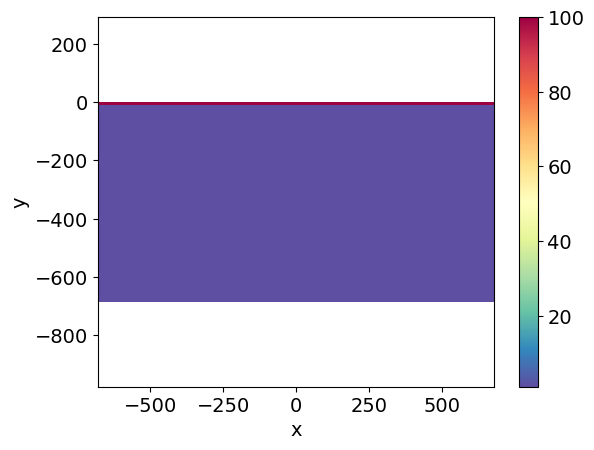

In [38]:

dd = mesh.plot_image(surface_weights[actind], pcolor_opts={"cmap": "Spectral_r"})
plt.axis('equal')
plt.colorbar(dd[0])

Orientation angle (degrees): -157.4387385903299 [186.95051409 173.12877559]
Orientation angle (degrees): -116.66078552945709 [151.85694658 135.19939129]


/tmp/ipykernel_142852/2412999569.py:69: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  d = meshCore.plotImage(conductivity_model_log10_true[actcore], clim=clim, ax=ax[0], pcolorOpts={'cmap':"Spectral_r"})
/home/juanito/mambaforge/envs/jresearch/lib/python3.11/site-packages/discretize/utils/code_utils.py:313: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  return getattr(self, new_name)(*args, **kwargs)
/tmp/ipykernel_142852/2412999569.py:72: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  d1 = meshCore.plotImage(conductivity_model_log10_geoseg[actcore], clim=clim, ax=ax[1], pcolorOpts={'cmap':"Spectral_r"})


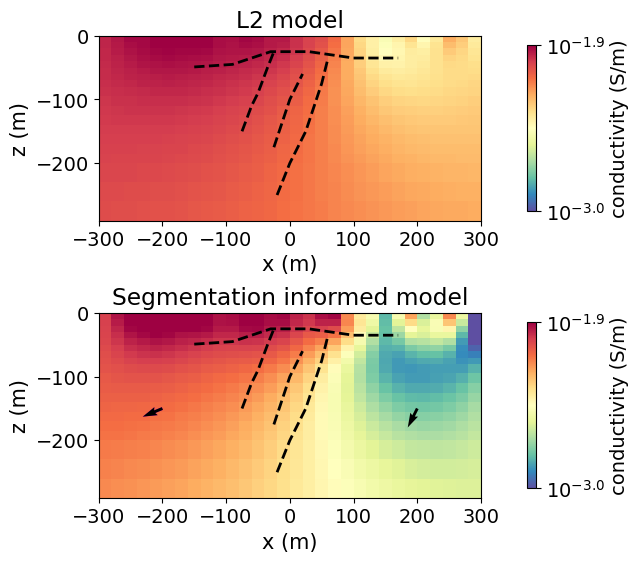

In [119]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
seg_data = masks_iter_2[1]['segmentation']  # results[2]['segmentation']
seg_data = np.flip(seg_data)
# Find the coordinates of the object pixels
object_pixels = np.argwhere(seg_data == 0)

# Apply PCA to determine orientation
if len(object_pixels) > 1:

    # Apply PPCA
    pca = PCA(n_components=2)
    pca.fit(object_pixels)

    # The first principal component (eigenvector) will represent the orientation
    orientation_vector = pca.components_[0]

    # Compute the angle of the orientation vector (in degrees)
    angle_degrees = np.arctan2(orientation_vector[1], orientation_vector[0]) * 180 / np.pi

    print(f"Orientation angle (degrees): {angle_degrees} {pca.singular_values_}")
    angle_radians = angle_degrees * np.pi / 180

object_pixels = np.argwhere(seg_data == 1)

# Apply PCA to determine orientation
if len(object_pixels) > 1:

    # Apply PPCA
    pca = PCA(n_components=2)
    pca.fit(object_pixels)

    # The first principal component (eigenvector) will represent the orientation
    orientation_vector = pca.components_[0]

    # Compute the angle of the orientation vector (in degrees)
    angle_degrees = np.arctan2(orientation_vector[1], orientation_vector[0]) * 180 / np.pi

    print(f"Orientation angle (degrees): {angle_degrees} {pca.singular_values_}")
    angle_radians2 = angle_degrees * np.pi / 180



fig, ax = plt.subplots(2, 1, figsize=(12, 6))
upper_clay = np.array([[-150, -90, -30, 30, 100, 170],
              [-49, -45, -25, -25, -35, -35]])
unit_west = np.array([[-75, -60, -50, -35, -25],
              [-150, -110, -90, -50, -25]])

unit_center = np.array([[-25, 0, 20],
              [-175, -100, -60]])

unit_east = np.array([[-20, 0, 25, 50, 60],
              [-250, -200, -150, -75, -35]])

xmin, xmax = -300., 300.
ymin, ymax = -300., 0.
zmin, zmax = 0, 0
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
from SimPEG import utils
actcore,  meshCore = utils.mesh_utils.extract_core_mesh(xyzlim, mesh)

# mcd_model =  discretize.TensorMesh.read_model_UBC(mesh, r"/home/juanito/Documents/projects/mcD/dflt/dcinv2d.con")
mcd_model =  np.exp(np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/mcd_iterations/model_24.npy"))
mcd_model2 =  np.exp(np.load(r"/home/juanito/Dropbox/JohnLindsey/geoseg/mcd_iterations/model_8.npy"))
conductivity_model_log10_true = np.log10(np.exp(np.log(mcd_model2)))
clim = [conductivity_model_log10_true.min(), conductivity_model_log10_true.max()]
clim = [-3, -1.9]
d = meshCore.plotImage(conductivity_model_log10_true[actcore], clim=clim, ax=ax[0], pcolorOpts={'cmap':"Spectral_r"})
plt.colorbar(d[0], cmap='Spectral_r', label=r'conductivity (S/m)', ticks=[clim[0],clim[1]], format="$10^{%.1f}$", shrink=0.9).ax.tick_params(labelsize=14)
conductivity_model_log10_geoseg = np.log10(np.exp(np.log(mcd_model)))
d1 = meshCore.plotImage(conductivity_model_log10_geoseg[actcore], clim=clim, ax=ax[1], pcolorOpts={'cmap':"Spectral_r"})
plt.colorbar(d1[0], cmap='Spectral_r', label=r'conductivity (S/m)', ticks=[clim[0],clim[1]], format="$10^{%.1f}$", shrink=0.9).ax.tick_params(labelsize=14)

# dd = mesh.plot_image(np.log(1 / mcd_model), ax=ax[0], clim=clim, pcolor_opts={"cmap": "Spectral"})
# dd1 = mesh.plot_image(np.log(1 / mcd_model2), ax=ax[1], clim=clim, pcolor_opts={"cmap": "Spectral"})
ax[0].plot(upper_clay[0, :], upper_clay[1, :], 'k--', lw=2, label="minerlized zone")
ax[0].plot(unit_west[0, :], unit_west[1, :], 'k--', lw=2)
ax[0].plot(unit_center[0, :], unit_center[1, :], 'k--', lw=2)
ax[0].plot(unit_east[0, :], unit_east[1, :], 'k--', lw=2)
ax[1].plot(upper_clay[0, :], upper_clay[1, :], 'k--', lw=2, label="minerlized zone")
ax[1].plot(unit_west[0, :], unit_west[1, :], 'k--', lw=2)
ax[1].plot(unit_center[0, :], unit_center[1, :], 'k--', lw=2)
ax[1].plot(unit_east[0, :], unit_east[1, :], 'k--', lw=2)

ax[0].set_title("L2 model")
ax[1].set_title("Segmentation informed model")
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[0].set_xlabel('x (m)',fontsize=15)
ax[0].set_ylabel('z (m)',fontsize=15)
ax[1].set_xlabel('x (m)',fontsize=15)
ax[1].set_ylabel('z (m)',fontsize=15)
plt.subplots_adjust(hspace=0.5)

u = np.cos(angle_radians)
v = np.sin(angle_radians)

# Create a quiver plot
arrow = ax[1].quiver([-200], [-150], u, v, color='m') 

u = np.cos(angle_radians)
v = np.sin(angle_radians)

# Create a quiver plot
arrow = ax[1].quiver([-200], [-150], u, v, color='k') 

u = np.cos(angle_radians2)
v = np.sin(angle_radians2)

# Create a quiver plot
arrow = ax[1].quiver([200], [-150], u, v, color='k') 

In [114]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
upper_clay = np.array([[-150, -90, -30, 30, 100, 170],
              [-49, -45, -25, -25, -35, -35]])
unit_west = np.array([[-75, -60, -50, -35, -25],
              [-150, -110, -90, -50, -25]])

unit_center = np.array([[-25, 0, 20],
              [-175, -100, -60]])

unit_east = np.array([[-20, 0, 25, 50, 60],
              [-250, -200, -150, -75, -35]])

xmin, xmax = -300., 300.
ymin, ymax = -300., 0.
zmin, zmax = 0, 0
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
from SimPEG import utils
actcore,  meshCore = utils.mesh_utils.extract_core_mesh(xyzlim, mesh)

# mcd_model =  discretize.TensorMesh.read_model_UBC(mesh, r"/home/juanito/Documents/projects/mcD/dflt/dcinv2d.con")
mcd_model =  np.exp(np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/mcd_iterations/model_6.npy"))
# mcd_model2 =  np.exp(np.load(r"/home/juanito/Dropbox/JohnLindsey/geoseg/mcd_iterations/model_8.npy"))
conductivity_model_log10_true = np.log10(np.exp(np.log(mcd_model2)))
clim = [conductivity_model_log10_true.min(), conductivity_model_log10_true.max()]
clim = [-3, -1.9]
d = meshCore.plotImage(conductivity_model_log10_true[actcore], clim=clim, ax=ax[0], pcolorOpts={'cmap':"Spectral_r"})
plt.colorbar(d[0], cmap='Spectral_r', label=r'conductivity (S/m)', ticks=[clim[0],clim[1]], format="$10^{%.1f}$", shrink=0.9).ax.tick_params(labelsize=14)


array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

/tmp/ipykernel_4154/1652909241.py:12: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  d1 = mesh.plotImage(mcd_model, clim=clim, ax=ax[0, 0], pcolorOpts={'cmap':"Spectral_r"})
/tmp/ipykernel_4154/1652909241.py:99: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  d3 = mesh.plotImage(flatten, clim=clim, ax=ax[1, 0], pcolorOpts={'cmap':"winter_r"})


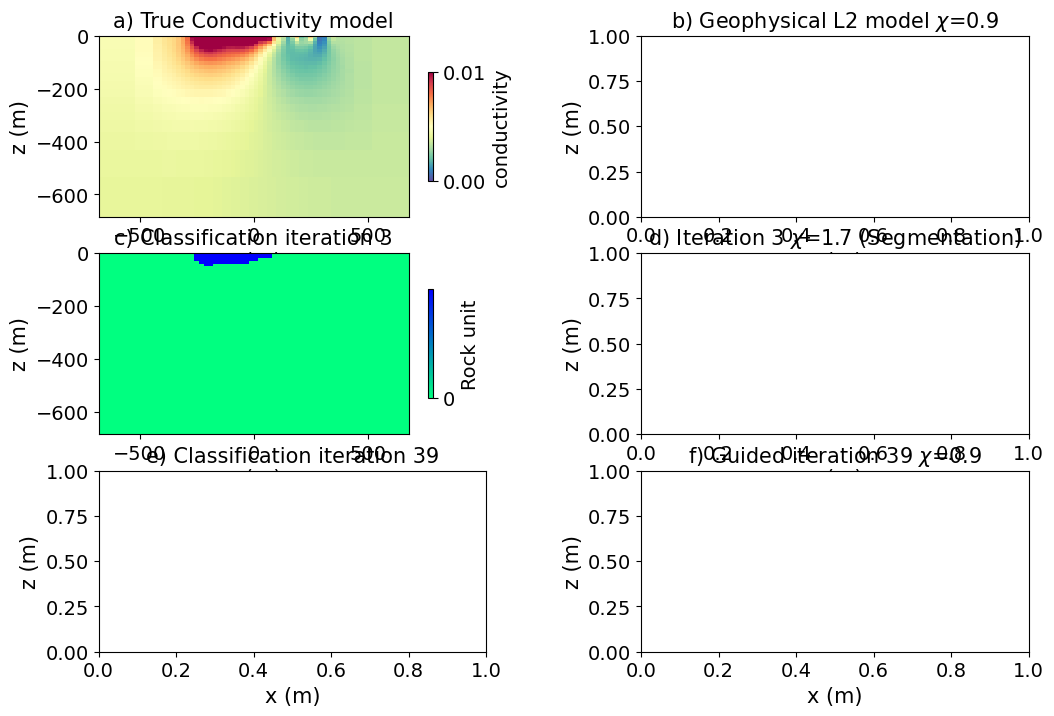

In [20]:
# from matplotlib.colors import LogNorm
# import matplotlib as mpl

sam_model = segmentor
fig, ax = plt.subplots(3, 2, figsize=(12, 8))


# subplot 0,0 ----------------------------------------------------------
flatten = mcd_model
conductivity_model_log10_true = np.log10(np.exp(flatten))
clim=[0, 0.01]  # clim = [conductivity_model_log10_true.min(), conductivity_model_log10_true.max()]
d1 = mesh.plotImage(mcd_model, clim=clim, ax=ax[0, 0], pcolorOpts={'cmap':"Spectral_r"})
plt.colorbar(d1[0], cmap='Spectral_r', label=r'conductivity', ticks=[clim[0],clim[1]], shrink=0.6).ax.tick_params(labelsize=14)
# clim = [np.log10(np.exp(dip_model3)).min(), np.log10(np.exp(dip_model3)).max()]
# d1 = utils.plot2Ddata(

#     meshCore.gridCC, conductivity_model_log10_true,nx=500,ny=500,
#     contourOpts={'cmap':"Spectral_r", 'alpha':1},
#     ax=ax[0, 0],
#     # level=True,
#     ncontour=5,
#     # shade=True,
#     # levelOpts={'colors':'k','linewidths':0.25},
#     method='linear',
#     # clim=clim,
#     shade_ncontour=100,
#     shade_azimuth=315.0,
#     shade_angle_altitude=45.0,
    
# )

# utils.plot2Ddata(

#     meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
#     contourOpts={'alpha':0},
#     #clim=[0,5],
#     ax=ax[0, 0],
#     level=True,
#     ncontour=2,
#     levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
#     method='nearest'
    
# )

# norm = mpl.colors.Normalize(
#     vmin=conductivity_model_log10_true.min(), vmax=conductivity_model_log10_true.max()
# )

# # plt.colorbar(d1[0], cmap='Spectral_r', norm=norm, orientation="horizontal", label='Conductivity [S/m]', format="$10^{%.1f}$", pad=0.2, shrink=0.95)


# # subplot 0,1 ----------------------------------------------------------

# utils.plot2Ddata(

#     meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
#     contourOpts={'alpha':0},
#     #clim=[0,5],
#     ax=ax[0, 1],
#     level=True,
#     ncontour=2,
#     # shade=True,
#     levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
#     method='nearest'
    
# )

# dip_model3 = np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/L2/model_10.npy")
# conductivity_model_log10 = np.log10(np.exp(dip_model3))
# clim = [conductivity_model_log10.min(), conductivity_model_log10.max()]
# d2 = meshCore.plotImage(conductivity_model_log10, clim=clim, ax=ax[0, 1], pcolorOpts={'cmap':"Spectral_r"})
# plt.colorbar(d2[0], cmap='Spectral_r', label=r'conductivity', ticks=[clim[0],clim[1]], format="$10^{%.1f}$", shrink=0.6).ax.tick_params(labelsize=14)
# # d2 = utils.plot2Ddata(

# #     meshCore.gridCC, conductivity_model_log10, nx=500,ny=500,
# #     contourOpts={'cmap':"Spectral_r", 'alpha':1},
# #     ax=ax[0, 1],
# #     level=True,
# #     ncontour=8,
# #     shade=True,
# #     levelOpts={'colors':'k','linewidths':0.25},
# #     method='linear',
# #     clim=clim,
# #     shade_ncontour=100,
# #     shade_azimuth=315.0,
# #     shade_angle_altitude=45.0,
    
# # )

# # norm = mpl.colors.Normalize(
# #     vmin=conductivity_model_log10.min(), vmax=conductivity_model_log10.max()
# # )

# # plt.colorbar(d2[0], cmap='Spectral_r', norm=norm, orientation="horizontal", label='Conductivity [S/m]', format="$10^{%.1f}$", pad=0.2, shrink=0.95)

# # subplot 1,0 ----------------------------------------------------------

flatten = masks_iter_2[1]['segmentation'].flatten(order='F')  # np.load('iter40-segmentations.npy').astype(int).flatten(order='F')
d3 = mesh.plotImage(flatten, clim=clim, ax=ax[1, 0], pcolorOpts={'cmap':"winter_r"})
# utils.plot2Ddata(

#     meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
#     contourOpts={'alpha':0},
#     ax=ax[1, 0],
#     level=True,
#     ncontour=2,
#     levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
#     method='nearest'
    
# )

# d3 = utils.plot2Ddata(

#     meshCore.gridCC, flatten.flatten(order='F'),nx=500,ny=500,
#     contourOpts={'cmap':"winter_r", 'alpha':1},
#     ax=ax[1, 0],
#     level=False,
#     ncontour=5,
#     # shade=True,
#     levelOpts={'colors':'k','linewidths':0.25},
#     method='linear',
#     # clim=[10, 500],
    
# )

# # norm_seg = mpl.colors.Normalize(
# #     vmin=conductivity_model_log10_seg.min(), vmax=conductivity_model_log10_seg.max()
# # )

plt.colorbar(d3[0], cmap='winter_r', label='Rock unit', ticks=[1,0], shrink=0.6).ax.tick_params(labelsize=14)

# # subplot 1,1 ----------------------------------------------------------

# utils.plot2Ddata(

#     meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
#     contourOpts={'alpha':0},
#     #clim=[0,5],
#     ax=ax[1, 1],
#     level=True,
#     ncontour=2,
#     levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
#     method='nearest'
    
# )

# dip_model1_1 = np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/iterations_adjusted_frame/model_2.npy")
# conductivity_model_log10_1_1 = np.log10(np.exp(dip_model1_1))
# d5 = meshCore.plotImage(conductivity_model_log10_1_1, clim=clim, ax=ax[1, 1], pcolorOpts={'cmap':"Spectral_r"})
# plt.colorbar(d5[0], cmap='Spectral_r', label=r'conductivity', ticks=[clim[0],clim[1]], format="$10^{%.1f}$", shrink=0.6).ax.tick_params(labelsize=14)
# # d5 = utils.plot2Ddata(

# #     meshCore.gridCC, conductivity_model_log10_1_1,nx=500,ny=500,
# #     contourOpts={'cmap':"Spectral_r", 'alpha':1},
# #     ax=ax[1, 1],
# #     level=True,
# #     ncontour=8,
# #     shade=True,
# #     levelOpts={'colors':'k','linewidths':0.25},
# #     method='linear',
# #     clim=clim,
# #     shade_ncontour=100,
# #     shade_azimuth=315.0,
# #     shade_angle_altitude=45.0,
    
# # )

# # # norm = mpl.colors.Normalize(
# # #     vmin=conductivity_model_log10_seg.min(), vmax=conductivity_model_log10_seg.max()
# # # )

# # plt.colorbar(d5[0], cmap='Spectral_r', norm=norm, orientation="horizontal", label='Conductivity [S/m]', format="$10^{%.1f}$", pad=0.2, shrink=0.95)

# # subplot 2,0 ----------------------------------------------------------

# utils.plot2Ddata(

#     meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
#     contourOpts={'alpha':0},
#     #clim=[0,5],
#     ax=ax[2, 0],
#     level=True,
#     ncontour=2,
#     levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
#     method='nearest'
    
# )

# flatten = np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/mask_3_dip_iter39.npy").astype(int) # masks_iter39[-1]['segmentation'].flatten(order='F')
# d6 = utils.plot2Ddata(

#     meshCore.gridCC, flatten.flatten(order='F'),nx=500,ny=500,
#     contourOpts={'cmap':"winter_r", 'alpha':1},
#     #clim=[0,5],
#     ax=ax[2, 0],
#     level=False,
#     ncontour=5,
#     # shade=True,
#     levelOpts={'colors':'k','linewidths':0.25},
#     method='linear',
#     # clim=[10, 500],
    
# )
# plt.colorbar(d6[0], cmap='winter_r', label='Rock unit', ticks=[0,1], shrink=0.6).ax.tick_params(labelsize=14)

# # subplot 2,1 ----------------------------------------------------------

# utils.plot2Ddata(

#     meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
#     contourOpts={'alpha':0},
#     #clim=[0,5],
#     ax=ax[2, 1],
#     level=True,
#     ncontour=2,
#     levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
#     method='nearest'
    
# )

# # flatten = masks3[3]['segmentation'].flatten(order='F')
# dip_model2_1 = np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/iterations_adjusted_frame/model_39.npy")
# conductivity_model_log10_2_1 = np.log10(np.exp(dip_model2_1))
# d7 = meshCore.plotImage(conductivity_model_log10_2_1, clim=clim, ax=ax[2, 1], pcolorOpts={'cmap':"Spectral_r"})
# plt.colorbar(d7[0], cmap='Spectral_r', label=r'conductivity', ticks=[clim[0],clim[1]], format="$10^{%.1f}$", shrink=0.6).ax.tick_params(labelsize=14)

ax[0, 1].set_title(r'b) Geophysical L2 model $\chi$=0.9',fontsize=15)
ax[0, 1].set_xlabel('x (m)',fontsize=15)
ax[0, 1].set_ylabel('z (m)',fontsize=15)


ax[0, 0].set_title('a) True Conductivity model',fontsize=15)
ax[0, 0].set_xlabel('x (m)',fontsize=15)
ax[0, 0].set_ylabel('z (m)',fontsize=15)

ax[1, 0].set_title('c) Classification iteration 3',fontsize=15)
ax[1, 0].set_xlabel('x (m)',fontsize=15)
ax[1, 0].set_ylabel('z (m)',fontsize=15)

# ax[1, 1].invert_yaxis()
ax[1, 1].set_title(r'd) Iteration 3 $\chi$=1.7 (Segmentation)',fontsize=15)
ax[1, 1].set_xlabel('x (m)',fontsize=15)
ax[1, 1].set_ylabel('z (m)',fontsize=15)

# ax[1, 1].invert_yaxis()
ax[2, 0].set_title('e) Classification iteration 39',fontsize=15)
ax[2, 0].set_xlabel('x (m)',fontsize=15)
ax[2, 0].set_ylabel('z (m)',fontsize=15)

# ax[1, 1].invert_yaxis()
ax[2, 1].set_title(r'f) Guided iteration 39 $\chi$=0.9',fontsize=15)
ax[2, 1].set_xlabel('x (m)',fontsize=15)
ax[2, 1].set_ylabel('z (m)',fontsize=15)

# plt.tight_layout()
plt.subplots_adjust(wspace=0.4)

In [120]:
# core python 
import geological_segmentation as geoseg
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# tools in the simPEG Ecosystem 
import discretize  # for creating computational meshes

# linear solvers
try: 
    from pymatsolver import Pardiso as Solver  # this is a fast linear solver 
except ImportError:
    from SimPEG import SolverLU as Solver  # this will be slower

# SimPEG inversion machinery
from SimPEG import (
    Data, maps,
    data_misfit, regularization, optimization, inverse_problem, 
    inversion, directives
) 
from SimPEG.utils.code_utils import validate_ndarray_with_shape

# DC resistivity and IP modules
from SimPEG.electromagnetics import resistivity as dc
from SimPEG.electromagnetics import induced_polarization as ip

from SimPEG.electromagnetics.static.utils.static_utils import (
    apparent_resistivity_from_voltage,
    plot_pseudosection,
)

# set the font size in the plots
from matplotlib import rcParams
rcParams["font.size"] = 14


class plot_mref(directives.InversionDirective):

    mesh = None
    
    def initialize(self):
        self.start = 0
        # self.endIter()
    
    def endIter(self):
        # plot
        meshCore = self.mesh
        # predicted = self.invProb.reg.gmmref.predict(self.opt.xc.reshape(-1, 1))
        fig,ax = plt.subplots(3,1,figsize=(15,5))
        mm = meshCore.plot_image(
            self.opt.xc, ax=ax[0],
            # clim=[-np.log(250),-np.log(10),],
            # clim=[0,500],
            pcolor_opts={'cmap':'Spectral_r'}
        )
        # fig,ax = plt.subplots(1,1,figsize=(15,5))
        mm2 = meshCore.plot_image(
            1 / np.exp(self.invProb.reg.objfcts[0].reference_model), ax=ax[1],
            # clim=[-np.log(250),-np.log(10),],
            clim=[0,500],
            pcolor_opts={'cmap':'Spectral_r'}
        )
        # ax.set_xlim([-750,750])
        # ax.set_ylim([-250,0])
        # fig,ax = plt.subplots(1,1,figsize=(15,5))
        # mmpred = meshCore.plot_image(
        #    predicted, ax=ax[3],
        #     # clim=[-np.log(250),-np.log(10),],
        #     pcolor_opts={'cmap':'Spectral'}
        # )
        
        #plt.colorbar(mm[0])
        # utils.plot2Ddata(
        #     meshCore.gridCC,1 / np.exp(mtrue[actcore]),nx=500,ny=500,
        #     contourOpts={'alpha':0},
        #     clim=[0,500],
        #     ax=ax[0],
        #     level=True,
        #     ncontour=2,
        #     levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
        #     method='nearest'
        # )

        ax[2].hist(1 / np.exp(self.opt.xc), 100)
        # ax[2].set_aspect(1)

        # ax[0].set_ylim([-15,0])
        # ax[0].set_xlim([-15,15])
        ax[0].set_aspect(1)
        # ax[1].set_ylim([-15,0])
        # ax[1].set_xlim([-15,15])
        ax[1].set_aspect(1)
        fig.savefig(f'./geological_segmentation/mcd_iterations/{self.start}.png')
        np.save(f'./geological_segmentation/mcd_iterations/model_{self.start}.npy', self.opt.xc)
        # plt.show()
        self.start += 1


# update the neighbors
class segment_iter(directives.InversionDirective):

    seg_iter = [13]
    segmentation_model: geoseg.SamClassificationModel=None
    method = 'bound_box'
    reg_rots = np.zeros(0)

    def rotation_matrix(self, angle):
        theta = np.radians(angle)
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        return np.array([[cos_theta, -sin_theta], [sin_theta, cos_theta]])

    
    def initialize(self):
        self.count = 0
    
    def endIter(self):

        print(f"Segmenting-iteration: {self.opt.iter}")
        if self.opt.iter in self.seg_iter:
            
            # self.reg[1][1].update_gradients(self.opt.xc)
            masks = self.segmentation_model.fit(self.opt.xc)

            mesh = self.segmentation_model.mesh
            reg_dirs = [np.identity(2) for _ in range(mesh.nC)]
            sqrt2 = np.sqrt(2)
            reg_rots = np.zeros(mesh.nC) + 90

            # loop through masks and assign rotations
            for ii in range(1, len(masks)):
                seg_data = masks[ii]['segmentation']
                seg_data = np.flip(seg_data)
                # Find the coordinates of the object pixels
                object_pixels = np.argwhere(seg_data == 1)

                # Apply PPCA to determine orientation
                if len(object_pixels) > 1:

                    # Apply PPCA
                    pca = PCA(n_components=2)
                    pca.fit(object_pixels)

                    # The first principal component (eigenvector) will represent the orientation
                    orientation_vector = pca.components_[0]
                    scales = pca.singular_values_

                    # Compute the angle of the orientation vector (in degrees)
                    angle_degrees = np.arctan2(orientation_vector[1], orientation_vector[0]) * 180 / np.pi

                    print(f"Orientation angle (degrees): {angle_degrees} and scales: {scales}")
                    angle_radians = angle_degrees * np.pi / 180
                    
                    # rotation_matrix = 1 / np.array([[sqrt2, -sqrt2], [-sqrt2, -sqrt2],])
                    alphas = np.ones((mesh.n_cells, mesh.dim))
                    # check for rotation application method
                    if self.method == 'bound_box':
                        bbox_mask = self.segmentation_model.get_bound_box_indicies(ii)

                        flatten = bbox_mask # masks[ii]['segmentation'].flatten(order='F')
                        reshape = flatten.reshape(mesh.shape_cells, order='F')

                        # plt.imshow(reshape.T)
                        # plt.title(f'mask: {ii + 1}')
                        # plt.gca().invert_yaxis()
                        # # plt.plot([x0, x1], [y0, y1], 'ok')
                        # plt.show()

                        for ii in range(mesh.nC):

                            if bbox_mask[ii] == 1:
                                # print('adjusting')
                                # reg_cell_dirs[ii] = np.array([[cos, -sin], [sin, cos],])
                                reg_rots[ii] = angle_degrees
                                alphas[ii] =  [scales[1], scales[0]* 3]

                        smoothed_rots = geoseg.gaussian_curvature(reg_rots.reshape((len(mesh.h[0]),len(mesh.h[1])), order="F"), smoothness=8).flatten(order="F")
                        # now assign the priciple axis to the rotation matrix
                        for ii in range(mesh.nC):

                            if np.abs(reg_rots[ii]) > 0:
                                # print('adjusting')
                                # reg_cell_dirs[ii] = np.array([[cos, -sin], [sin, cos],])
                                rot_matrix = self.rotation_matrix(smoothed_rots[ii])
                                rotation_axis = np.array([rot_matrix[1, :].tolist(), rot_matrix[0, :].tolist(),])
                                reg_dirs[ii] = rotation_axis
                                
                        #         alphas[ii] = [150, 25]
                        # reg_dirs[bbox_mask] = [rotation_matrix] * int(bbox_mask.sum())
                    else:
                        reg_dirs[seg_data] = [rotation_matrix] * seg_data.sum()

                    reg_dirs = validate_ndarray_with_shape(
                        "reg_dirs",
                        reg_dirs,
                        shape=[(mesh.dim, mesh.dim), ("*", mesh.dim, mesh.dim)],
                        dtype=float,
                    )
                    
                    reg_seg = geoseg.GeologicalSegmentation(

                        mesh, 
                        reg_dirs=reg_dirs,
                        alphas=alphas,
                        ortho_check=False,

                    )

                    reg_small = regularization.Smallness(
                        mesh=mesh,
                        reference_model=self.reg[0][1].reference_model,
                        )


                    self.reg = reg_small + reg_seg
                    self.reg.multipliers = np.r_[1e-5, 1000.0]
                    self.invProb.reg = self.reg
                    # self.invProb.beta = 100.0
                    self.reg_rots = smoothed_rots

                else:
                    raise ValueError("Not enough object pixels to determine orientation.")


        
        self.count += 1



def read_dcip_data(filename, verbose=True):
    """
    Read in a .OBS file from the Century data set into a python dictionary. 
    The format is the old UBC-GIF DCIP format.
    
    Parameters
    ----------
    filename : str
        Path to the file to be parsed
    
    verbose: bool
        Print some things? 
    
    
    Returns
    -------
    dict
        A dictionary with the locations of
        - a_locations: the positive source electrode locations (numpy array) 
        - b_locations: the negative source electrode locations (numpy array) 
        - m_locations: the receiver locations (list of numpy arrays)
        - n_locations: the receiver locations (list of numpy arrays)
        - observed_data: observed data (list of numpy arrays)
        - standard_deviations: assigned standard deviations (list of numpy arrays)
        - n_sources: number of sources (int)
    
    """
    
    # read in the text file as a numpy array of strings (each row is an entry)
    contents = np.genfromtxt(filename, skip_header=2)

    unique_rows = np.unique(contents[:, :2], axis=0)

    dc_data = {}

    for i, row in enumerate(unique_rows):

        print(f"Source {i}: A-loc: {row[0]}, B-loc: {row[1]}")

        dc_data[f"{row[0]} {row[1]}"] = {'a': row[0], 'b': row[1], 'm': [], 'n': [], 'd': []}

    for ii in range(contents.shape[0]):

        dc_data[f"{contents[ii, 0]} {contents[ii, 1]}"]['m'] += [contents[ii, 2]]
        dc_data[f"{contents[ii, 0]} {contents[ii, 1]}"]['n'] += [contents[ii, 3]]
        dc_data[f"{contents[ii, 0]} {contents[ii, 1]}"]['d'] += [contents[ii, 4]]

    source_list = []

    sources = list(dc_data.keys())
    
    for jj in range(len(dc_data.keys())):
    
        # receiver electrode locations in 2D 
        m_locs = np.vstack([
            dc_data[sources[jj]]['m'], 
            np.zeros_like(dc_data[sources[jj]]["m"])
        ]).T
        n_locs = np.vstack([
            dc_data[sources[jj]]["n"],
            np.zeros_like(dc_data[sources[jj]]["n"])
        ]).T
        
        # construct the receiver object 
        receivers = dc.receivers.Dipole(locations_m=m_locs, locations_n=n_locs)
        
        # construct the source 
        source = dc.sources.Dipole(
            location_a=np.r_[dc_data[sources[jj]]["a"], 0.],
            location_b=np.r_[dc_data[sources[jj]]["b"], 0.],
            receiver_list=[receivers]
        )
        
        # append the new source to the source list
        source_list.append(source)

        survey_obj = dc.Survey(source_list=source_list)
        survey_obj.dobs = contents[:, 4]

    return survey_obj


dc_data_file = "/home/juanito/Documents/projects/mcD/mcd-dc.dat"
ip_data_file = "/home/juanito/Documents/projects/mcD/mcd-ip.dat"

dc_survey = read_dcip_data(dc_data_file)
ip_survey = read_dcip_data(ip_data_file)

Source 0: A-loc: -200.0, B-loc: -160.0
Source 1: A-loc: -160.0, B-loc: -120.0
Source 2: A-loc: -120.0, B-loc: -80.0
Source 3: A-loc: -80.0, B-loc: -40.0
Source 4: A-loc: -40.0, B-loc: 0.0
Source 5: A-loc: 0.0, B-loc: 40.0
Source 6: A-loc: 40.0, B-loc: 80.0
Source 7: A-loc: 80.0, B-loc: 120.0
Source 8: A-loc: 120.0, B-loc: 160.0
Source 9: A-loc: 160.0, B-loc: 200.0
Source 10: A-loc: 200.0, B-loc: 240.0
Source 11: A-loc: 240.0, B-loc: 280.0
Source 12: A-loc: 280.0, B-loc: 320.0
Source 13: A-loc: 320.0, B-loc: 360.0
Source 0: A-loc: -200.0, B-loc: -160.0
Source 1: A-loc: -160.0, B-loc: -120.0
Source 2: A-loc: -120.0, B-loc: -80.0
Source 3: A-loc: -80.0, B-loc: -40.0
Source 4: A-loc: -40.0, B-loc: 0.0
Source 5: A-loc: 0.0, B-loc: 40.0
Source 6: A-loc: 40.0, B-loc: 80.0
Source 7: A-loc: 80.0, B-loc: 120.0
Source 8: A-loc: 120.0, B-loc: 160.0
Source 9: A-loc: 160.0, B-loc: 200.0
Source 10: A-loc: 200.0, B-loc: 240.0
Source 11: A-loc: 240.0, B-loc: 280.0
Source 12: A-loc: 280.0, B-loc: 320.0


(array([ 5., 12.,  9., 11.,  6.,  2.,  1.,  0.,  2.,  4.]),
 array([-1.  , -0.34,  0.32,  0.98,  1.64,  2.3 ,  2.96,  3.62,  4.28,
         4.94,  5.6 ]),
 <BarContainer object of 10 artists>)

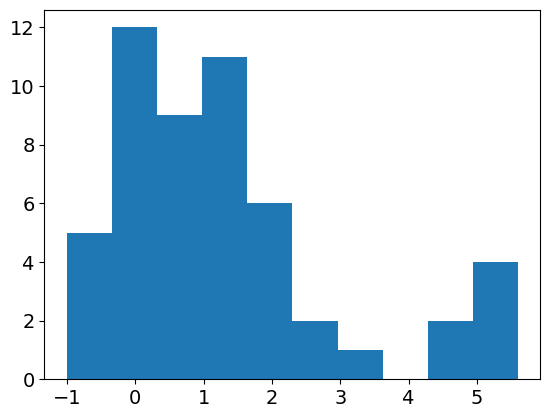

In [123]:
plt.hist(ip_survey.dobs)